In [15]:
from pyspark.sql import SparkSession
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Load Spark Output") \
    .getOrCreate()

# Define the path to the CSV file
file_path = "../data/engineered/calgary_housing_features.csv"  

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File does not exist: {file_path}")
    parent_dir = os.path.dirname(file_path)
    print(f"Parent directory contents: {os.listdir(parent_dir)}")
else:
    print(f"File exists: {file_path}. Loading data...")

    # Load the CSV file into a Spark DataFrame
    df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

    # Show data from Spark DataFrame
    print("Data loaded into Spark DataFrame:")
    df_spark.printSchema()
    df_spark.show(5)

    # Convert to Pandas DataFrame for further analysis if needed
    print("Converting Spark DataFrame to Pandas...")
    df_pandas = df_spark.toPandas()
    print("Data converted to Pandas DataFrame. Displaying top rows:")
    print(df_pandas.head())


File exists: ../data/engineered/calgary_housing_features.csv. Loading data...
Data loaded into Spark DataFrame:
root
 |-- roll_year: integer (nullable = true)
 |-- roll_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- assessed_value: double (nullable = true)
 |-- assessment_class: string (nullable = true)
 |-- assessment_class_description: string (nullable = true)
 |-- re_assessed_value: double (nullable = true)
 |-- comm_name: string (nullable = true)
 |-- land_use_designation: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- land_size_sm: double (nullable = true)
 |-- land_size_sf: double (nullable = true)
 |-- land_size_ac: double (nullable = true)
 |-- nr_assessed_value: double (nullable = true)
 |-- year_of_construction: integer (nullable = true)
 |-- sub_property_use: string (nullable = true)
 |-- fl_assessed_value: double (nullable = true)
 |-- property_age: integer (nullable = true)
 |-- price_per_sqft: double (nullable = t

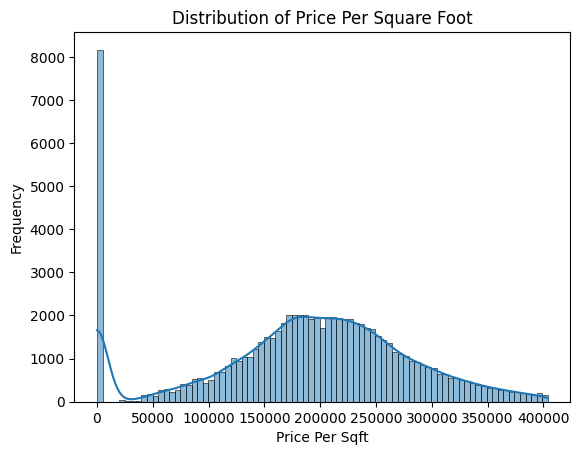

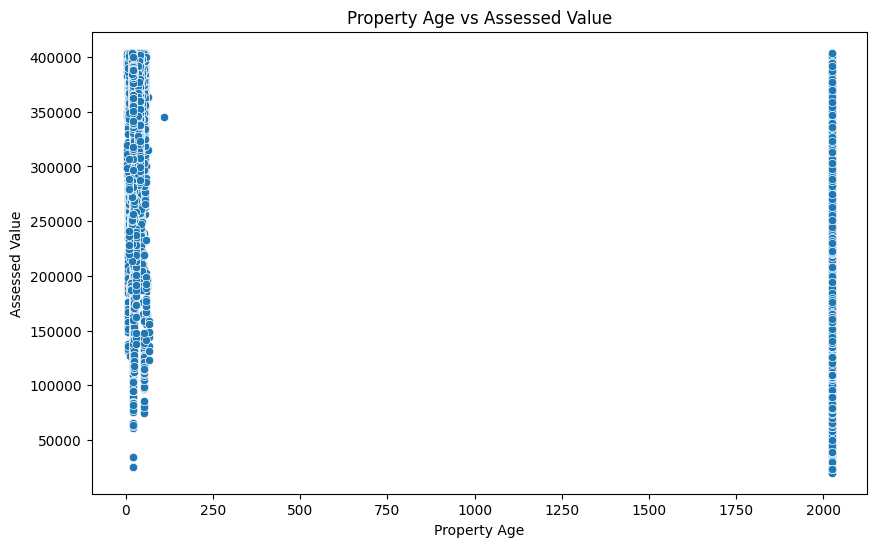

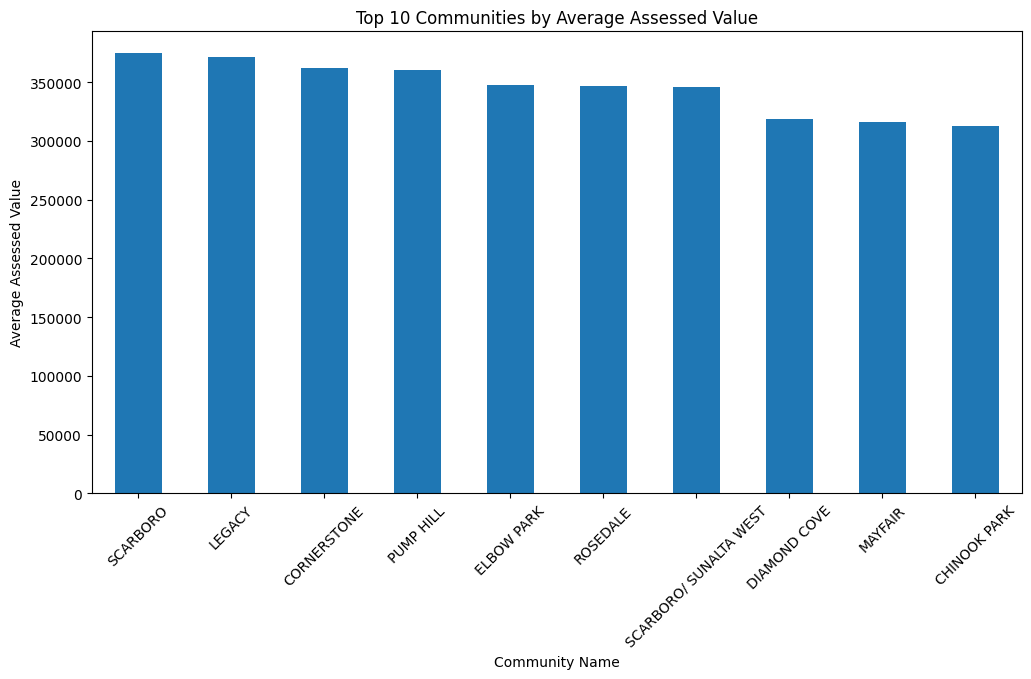

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize price per square foot distribution
sns.histplot(df_pandas["price_per_sqft"], kde=True)
plt.title("Distribution of Price Per Square Foot")
plt.xlabel("Price Per Sqft")
plt.ylabel("Frequency")
plt.show()

# Visualize property age vs assessed value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pandas["property_age"], y=df_pandas["assessed_value"])
plt.title("Property Age vs Assessed Value")
plt.xlabel("Property Age")
plt.ylabel("Assessed Value")
plt.show()

# Visualize average community value (bar chart)
avg_comm_value = df_pandas.groupby("comm_name")["avg_comm_value"].mean().sort_values(ascending=False).head(10)
avg_comm_value.plot(kind="bar", figsize=(12, 6))
plt.title("Top 10 Communities by Average Assessed Value")
plt.xlabel("Community Name")
plt.ylabel("Average Assessed Value")
plt.xticks(rotation=45)
plt.show()


Reading prediction data from: ../data/predictions/re_assessed_value_predictions.csv/


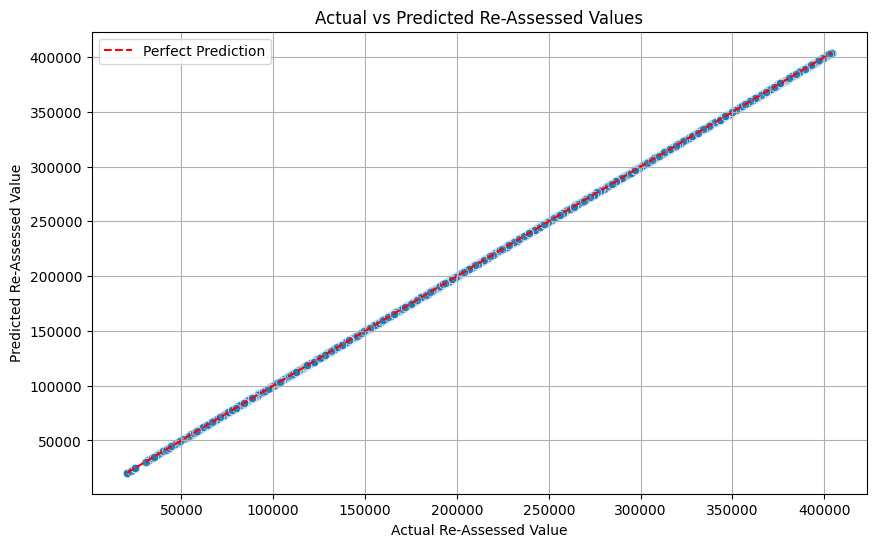

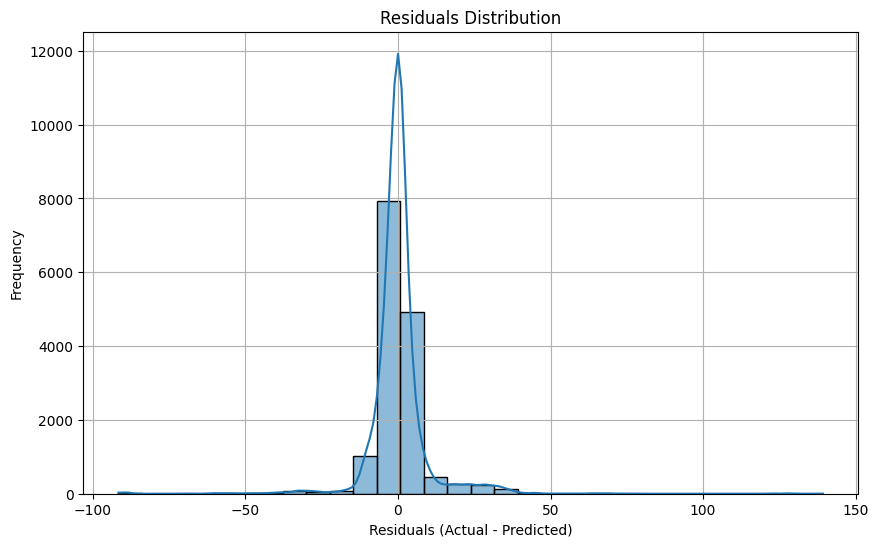

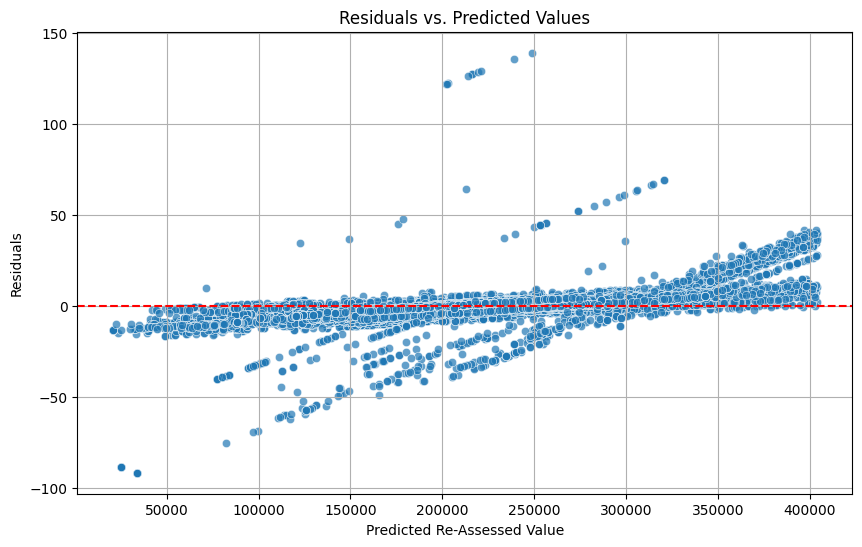

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Load predictions from sharded CSV file
predictions_path = "../data/predictions/re_assessed_value_predictions.csv/" 
print(f"Reading prediction data from: {predictions_path}")

# Combine all sharded parts into a single DataFrame
all_parts = glob.glob(os.path.join(predictions_path, "part-*"))
predictions_pandas = pd.concat([pd.read_csv(part) for part in all_parts], ignore_index=True)

# Ensure column names are consistent and correct
predictions_pandas.columns = ["features", "re_assessed_value", "prediction"]

# Convert necessary columns to numeric for visualization
predictions_pandas["re_assessed_value"] = pd.to_numeric(predictions_pandas["re_assessed_value"])
predictions_pandas["prediction"] = pd.to_numeric(predictions_pandas["prediction"])

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x="re_assessed_value", y="prediction", data=predictions_pandas, alpha=0.7)
plt.title("Actual vs Predicted Re-Assessed Values")
plt.xlabel("Actual Re-Assessed Value")
plt.ylabel("Predicted Re-Assessed Value")
plt.plot([predictions_pandas["re_assessed_value"].min(), predictions_pandas["re_assessed_value"].max()],
         [predictions_pandas["re_assessed_value"].min(), predictions_pandas["re_assessed_value"].max()],
         color="red", linestyle="--", label="Perfect Prediction")
plt.legend()
plt.grid(True)
plt.show()

# Residuals distribution
predictions_pandas["residuals"] = predictions_pandas["re_assessed_value"] - predictions_pandas["prediction"]
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pandas["residuals"], kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Residuals vs. Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="residuals", data=predictions_pandas, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Re-Assessed Value")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()
